# Panel estimation of wildifire probability 

In [1]:
import pandas as pd
from tsraster.prep import combine_extracted_features, combine_target_rasters, wide_to_long_target_features,unmask_df,panel_lag_1
from tsraster.calculate import checkRelevance2
from numpy import NaN

import tsraster.prep  as tr
import tsraster.model  as md
import rasterio
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier

### Organize data

append all features to one dataframe

In [2]:

path = r'G:\Climate_feature_subset_train'

concatenated_attribute_df = combine_extracted_features(path,write_out=False)


Combining folder year names ['19861990', '19861990', '19861990', '19861990', '19861990', '19861990', '19911995', '19911995', '19911995', '19911995', '19911995', '19911995', '19962000', '19962000', '19962000', '19962000', '19962000', '19962000']


C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv2\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


collect multitple years of Y (target) data

In [3]:
path = r"G:\Fire_target_train"
target_file_prefix = 'fire_'

concatenated_target_df = combine_target_rasters(path,
                                                target_file_prefix,
                                                write_out=False)

mask both the attribute data and targets 

In [4]:
raster_mask =u"F:/Boundary/StatePoly_buf.tif"
original_df = [concatenated_attribute_df, concatenated_target_df]

mask_attributes_df, mask_target_df = tr.mask_df(raster_mask, 
                                                original_df,  
                                                missing_value=-9999)

switch panel data from wide to long format

In [5]:

target_ln, features_ln = wide_to_long_target_features(target = mask_target_df,
                                                      features = mask_attributes_df,
                                                      sep='-')

converted to long, indexes match


In [6]:
print(mask_attributes_df.shape)
print(features_ln.shape)
features_ln.head(10)

(424284, 415)
(1272852, 138)


,,cwd__quantile__q_0.15,pck__last_location_of_maximum,"tmx__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""",pck__mean_change,"tmx__agg_linear_trend__f_agg_""min""__chunk_len_6__attr_""slope""",tmx__last_location_of_minimum,aet__last_location_of_maximum,pck__quantile__q_0.85,pet__count_below_mean,pet__quantile__q_0.95,...,aet__median,aet__last_location_of_minimum,pet__last_location_of_maximum,pck__skewness,pet__median,ppt__mean,cwd__mean,aet__count_below_mean,cwd__maximum,pet__number_cwt_peaks__n_6
index,time,,,,,,,,,,,,,,,,,,,,,
125174,19861990,0.0,1.000000,-0.072938,0.0,-0.231067,0.770833,0.625,0.0,24.0,167.186594,...,30.248199,0.166667,0.645833,0.000000,82.171997,173.269882,33.159119,29.0,156.451996,5.0
125175,19861990,0.0,1.000000,-0.051191,0.0,-0.225009,0.770833,0.625,0.0,24.0,166.298798,...,30.265999,0.166667,0.645833,0.000000,81.554001,173.052292,33.374016,29.0,157.313995,5.0
125176,19861990,0.0,1.000000,-0.037262,0.0,-0.221226,0.770833,0.625,0.0,24.0,165.652254,...,29.977501,0.166667,0.645833,0.000000,80.625000,174.348923,32.926769,29.0,155.255005,5.0
125177,19861990,0.0,0.770833,-0.030452,0.0,-0.230643,0.770833,0.625,0.0,24.0,168.475402,...,29.822399,0.166667,0.645833,6.928204,81.893997,169.196960,33.945312,29.0,157.246002,5.0
125178,19861990,0.0,1.000000,-0.040476,0.0,-0.239191,0.770833,0.625,0.0,24.0,178.671806,...,29.661600,0.166667,0.645833,0.000000,83.268005,154.772644,35.415165,29.0,159.927994,5.0
125179,19861990,0.0,1.000000,-0.029018,0.0,-0.237601,0.770833,0.625,0.0,24.0,179.695243,...,34.408249,0.416667,0.645833,0.000000,81.910004,150.901917,29.636114,28.0,146.485001,5.0
125180,19861990,0.0,1.000000,-0.020685,0.0,-0.238524,0.770833,0.625,0.0,24.0,175.310002,...,27.085751,0.166667,0.645833,0.000000,79.532501,159.657364,36.741314,29.0,163.749496,5.0
125181,19861990,0.0,1.000000,-0.014276,0.0,-0.225286,0.770833,0.625,0.0,24.0,170.830802,...,28.175999,0.166667,0.645833,0.000000,79.195999,172.827621,33.732784,29.0,159.429993,5.0
125182,19861990,0.0,0.770833,0.034090,0.0,-0.196190,0.770833,0.625,0.0,24.0,163.715395,...,29.374001,0.166667,0.645833,6.928204,77.731995,192.132339,31.249350,29.0,148.087601,5.0


add lagged variables 

In [7]:

lag_vars = ['ppt__maximum',
 'tmx__agg_linear_trend__f_agg_"max"__chunk_len_6__attr_"slope"',
 'ppt__mean_change',
 'cwd__agg_linear_trend__f_agg_"min"__chunk_len_6__attr_"slope"',
 'ppt__agg_linear_trend__f_agg_"min"__chunk_len_6__attr_"slope"',
 'pet__agg_linear_trend__f_agg_"max"__chunk_len_6__attr_"slope"',
 'ppt__agg_linear_trend__f_agg_"max"__chunk_len_6__attr_"slope"',
 'cwd__mean_change',
 'tmx__agg_linear_trend__f_agg_"min"__chunk_len_6__attr_"slope"',
 'ppt__median']   #[x for x in feature_importances.iloc[:10,0].index]


#features_ln = panel_lag_1(features_ln, col_names=features_ln.columns, group_by_index ='time')
features_ln = panel_lag_1(features_ln, 
                          col_names=lag_vars, 
                          group_by_index ='index')

print(features_ln.shape)


(848568, 148)


join and test train split yX data

In [8]:
obj = [target_ln,features_ln]

#from sklearn.preprocessing import StandardScaler as scaler
X_train, X_test, y_train, y_test = md.get_data(obj,
                                            stratify=True,
                                            test_size=0.9,
                                            scale=False)

input should be csv or pandas dataframe with yX, or [y,X]
reading in list


### Filter variables and train model

Find relevant variables and combine Y and X data

In [9]:
relevant_vars, X_train_relevant = checkRelevance2(X_train,y_train,fdr_level=0.001) #
print(relevant_vars)

X_test_relevant = X_test[X_train_relevant.columns]

                                                                                              feature  \
feature                                                                                                 
ppt__maximum                                                                             ppt__maximum   
ppt__agg_linear_trend__f_agg_"max"__chunk_len_6...  ppt__agg_linear_trend__f_agg_"max"__chunk_len_...   
aet__skewness                                                                           aet__skewness   
ppt__quantile__q_0.95                                                           ppt__quantile__q_0.95   
ppt__quantile__q_0.85                                                           ppt__quantile__q_0.85   
aet__mean                                                                                   aet__mean   
aet__sum_values                                                                       aet__sum_values   
ppt__mean                                              

[148 rows x 4 columns]


train a gradient booster classifier 

In [10]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1,
                                 max_depth=2, random_state=0).fit(X_train[X_train_relevant.columns], y_train)

 

In [13]:
predict_test = clf.predict(X=X_test[X_train_relevant.columns])

test_acc = accuracy_score(y_test, predict_test)
kappa = cohen_kappa_score(y_test, predict_test)
confusion = confusion_matrix(y_test, predict_test)

print('Testing accuracy:',test_acc)
print('Testing Kappa: ',kappa)
print('Testing Conf: ')
print(confusion)

Testing accuracy: 0.9847835309645521
Testing Kappa:  0.11383926354000529
Testing Conf: 
[[751320    855]
 [ 10766    771]]


Look at feature importance

In [16]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_test_relevant.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
feature_importances.head(10)

,importance
"ppt__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""_1",0.048575
cwd__mean_change,0.048088
pet__quantile__q_0.05,0.041436
ppt__mean_change,0.039383
cwd__mean_change_1,0.037285
ppt__mean_change_1,0.034531
ppt__maximum,0.034318
aet__mean_change,0.033224
"ppt__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""",0.032725
"pet__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""_1",0.032183


predict to all observations in panel
get predicted class and probability of class

In [17]:
concatenated_df_predict = md.model_predict(model = clf,
                                        new_X = features_ln[X_train_relevant.columns])

concatenated_df_prob =  md.model_predict_prob(model = clf,
                                        new_X = features_ln[X_train_relevant.columns])

isolate one 5 year period for mapping 


In [18]:

concatenated_df_prob_1996 = concatenated_df_prob.query('time == "19962000" ')
concatenated_df_prob_1996.index = concatenated_df_prob_1996.index.get_level_values(0) 

concatenated_df_prob_1996.describe()

,0,1
count,4.242840e+05,424284.000000
mean,9.817085e-01,0.018291
std,5.386175e-02,0.053862
min,1.163536e-11,0.000010
25%,9.841468e-01,0.001461
50%,9.949564e-01,0.005044
75%,9.985387e-01,0.015853
max,9.999902e-01,1.000000


unmask values 

In [20]:

unmask_concatenated_df_prob_1996 = tr.unmask_df(concatenated_attribute_df, 
                                                concatenated_df_prob_1996)

 
unmask_concatenated_df_prob_1996 = unmask_df(original_df = concatenated_attribute_df,
                                             mask_df_output = concatenated_df_prob_1996) 

# keep only class prob of fire event 
unmask_concatenated_df_prob_1996 = unmask_concatenated_df_prob_1996.iloc[:,1]
unmask_concatenated_df_prob_1996[unmask_concatenated_df_prob_1996== -9999 ]= NaN 

unmask_concatenated_df_prob_1996.describe()

count    424284.000000
mean          0.018291
std           0.053862
min           0.000010
25%           0.001461
50%           0.005044
75%           0.015853
max           1.000000
Name: 1, dtype: float64

### rasterize and plot prediction

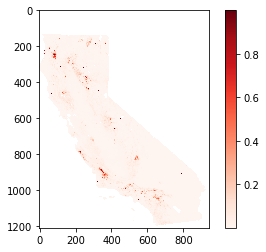

In [38]:
raster_ex = "F:/5year/aet/aet-201201.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = unmask_concatenated_df_prob_1996.values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

compare to actual

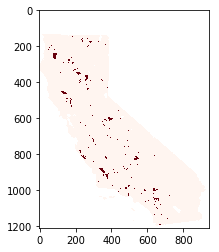

In [39]:

path = r"G:\Fire_target_train\fire_1996_2000.tif"
image_name = tr.image_names(path)
rasters = tr.image_to_array(path)[:,:,0]
rasters[isnan(f2Array)] = nan

plt.imshow(rasters)
plt.set_cmap("Reds")
plt.show()
